In [1]:
cd ../..

/home


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import os

from sklearn.metrics import r2_score, mean_squared_error

from core.astromer import get_ASTROMER, train, predict
from core.data  import pretraining_records

from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from tensorboard.backend.event_processing import event_accumulator


%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [3]:
exp_path = './weights/astromer_10022021/'

In [4]:
conf_file = os.path.join(exp_path, 'conf.json')

with open(conf_file, 'r') as handle:
    conf = json.load(handle)
conf

{'max_obs': 200,
 'data': './data/records/huge',
 'p': './runs/huge_5/finetuning/huge_6',
 'prefix': 'huge_2',
 'batch_size': 5000,
 'epochs': 10000,
 'patience': 200,
 'layers': 2,
 'heads': 4,
 'head_dim': 256,
 'dff': 128,
 'dropout': 0.1,
 'base': 1000,
 'lr': 0.001,
 'use_leak': False,
 'no_train': False,
 'no_shuffle': False,
 'msk_frac': 0.5,
 'rnd_frac': 0.2,
 'same_frac': 0.2,
 'exp_date': '2021-09-29 02:34:42'}

In [5]:
dataset_path = './data/records/alcock/fold_0/alcock_20/'
test_batches = pretraining_records(os.path.join(dataset_path, 'test'), 
                            256, 
                            max_obs=conf['max_obs'],
                            msk_frac=conf['msk_frac'],
                            rnd_frac=conf['rnd_frac'],
                            same_frac=conf['same_frac'],
                            sampling=False, shuffle=False)

df_objects = pd.read_csv(os.path.join(dataset_path, 'objects.csv'))
class_names = df_objects['label'].values
df_objects.sum()

2022-07-15 20:49:38.956896: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-15 20:49:38.956942: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: f2d80638b482
2022-07-15 20:49:38.956951: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: f2d80638b482
2022-07-15 20:49:38.957101: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.32.3
2022-07-15 20:49:38.957125: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.32.3
2022-07-15 20:49:38.957132: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.32.3
2022-07-15 20:49:38.957521: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instruct

label    Cep_0Cep_1ECLPVRRabRRc
size                        120
dtype: object

In [6]:
# from core.data  import from_generator
# test_batches = from_generator(conf['max_obs'], 100, 16)

In [7]:
astromer = get_ASTROMER(num_layers=conf['layers'],
                        d_model=conf['head_dim'],
                        num_heads=conf['heads'],
                        dff=conf['dff'],
                        base=conf['base'],
                        use_leak=conf['use_leak'],
                        dropout=conf['dropout'],
                        maxlen=conf['max_obs'])

In [8]:
# tf.keras.utils.plot_model(astromer, show_shapes=True)

In [9]:
weights_path = 'weights/astromer_10022021/weights'
astromer.load_weights(weights_path)

In [10]:
encoder = astromer.get_layer('encoder')

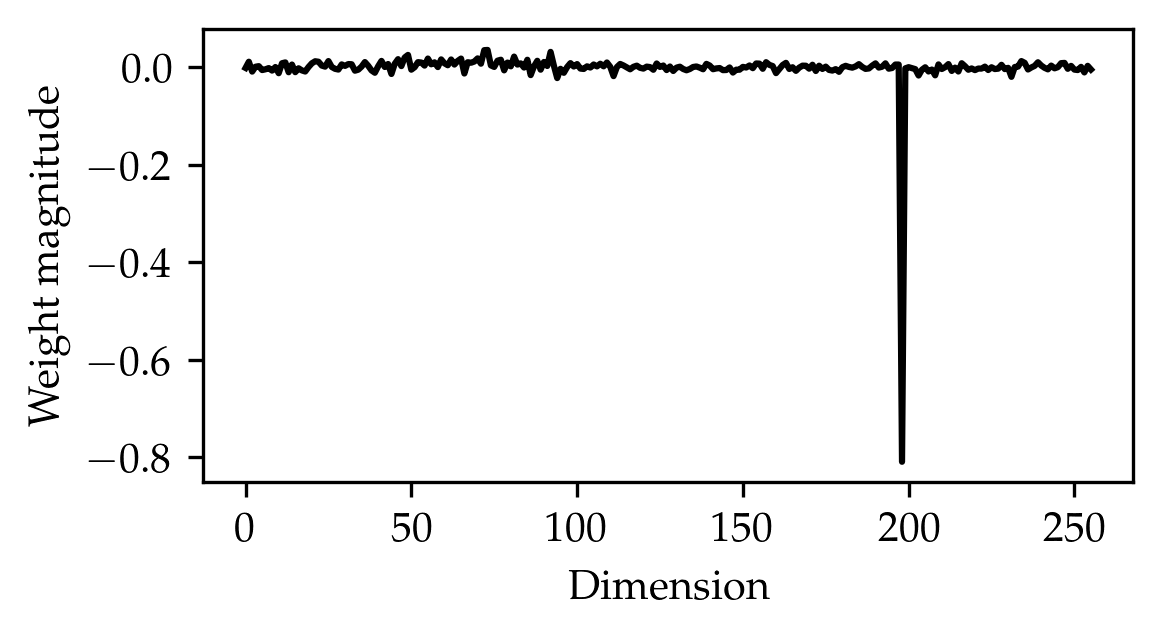

In [27]:
plt.figure(figsize=(4,2), dpi=300)
plt.plot(encoder.inp_transform.weights[0][0], color='k')
plt.ylabel('Weight magnitude')
plt.xlabel('Dimension')
plt.savefig('./presentation/figures/add_x_pe.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [27]:
%%time
result = predict(astromer, test_batches, conf)

prediction: 0it [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['output', 'mask_out', 'label', 'id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
prediction: 56it [00:06,  9.11it/s]

CPU times: user 20.7 s, sys: 2.69 s, total: 23.3 s
Wall time: 6.32 s


In [28]:
print('r2: {}\nmse: {}'.format(r2_score(result['x_true'][...,0], result['x_pred'][...,0]), 
                               result['mse']))

r2: 0.8171855736754687
mse: 0.10364657640457153


In [27]:
r2 = [0.82]
mse = [0.03]

/tmp/ipykernel_3099515/3053204551.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


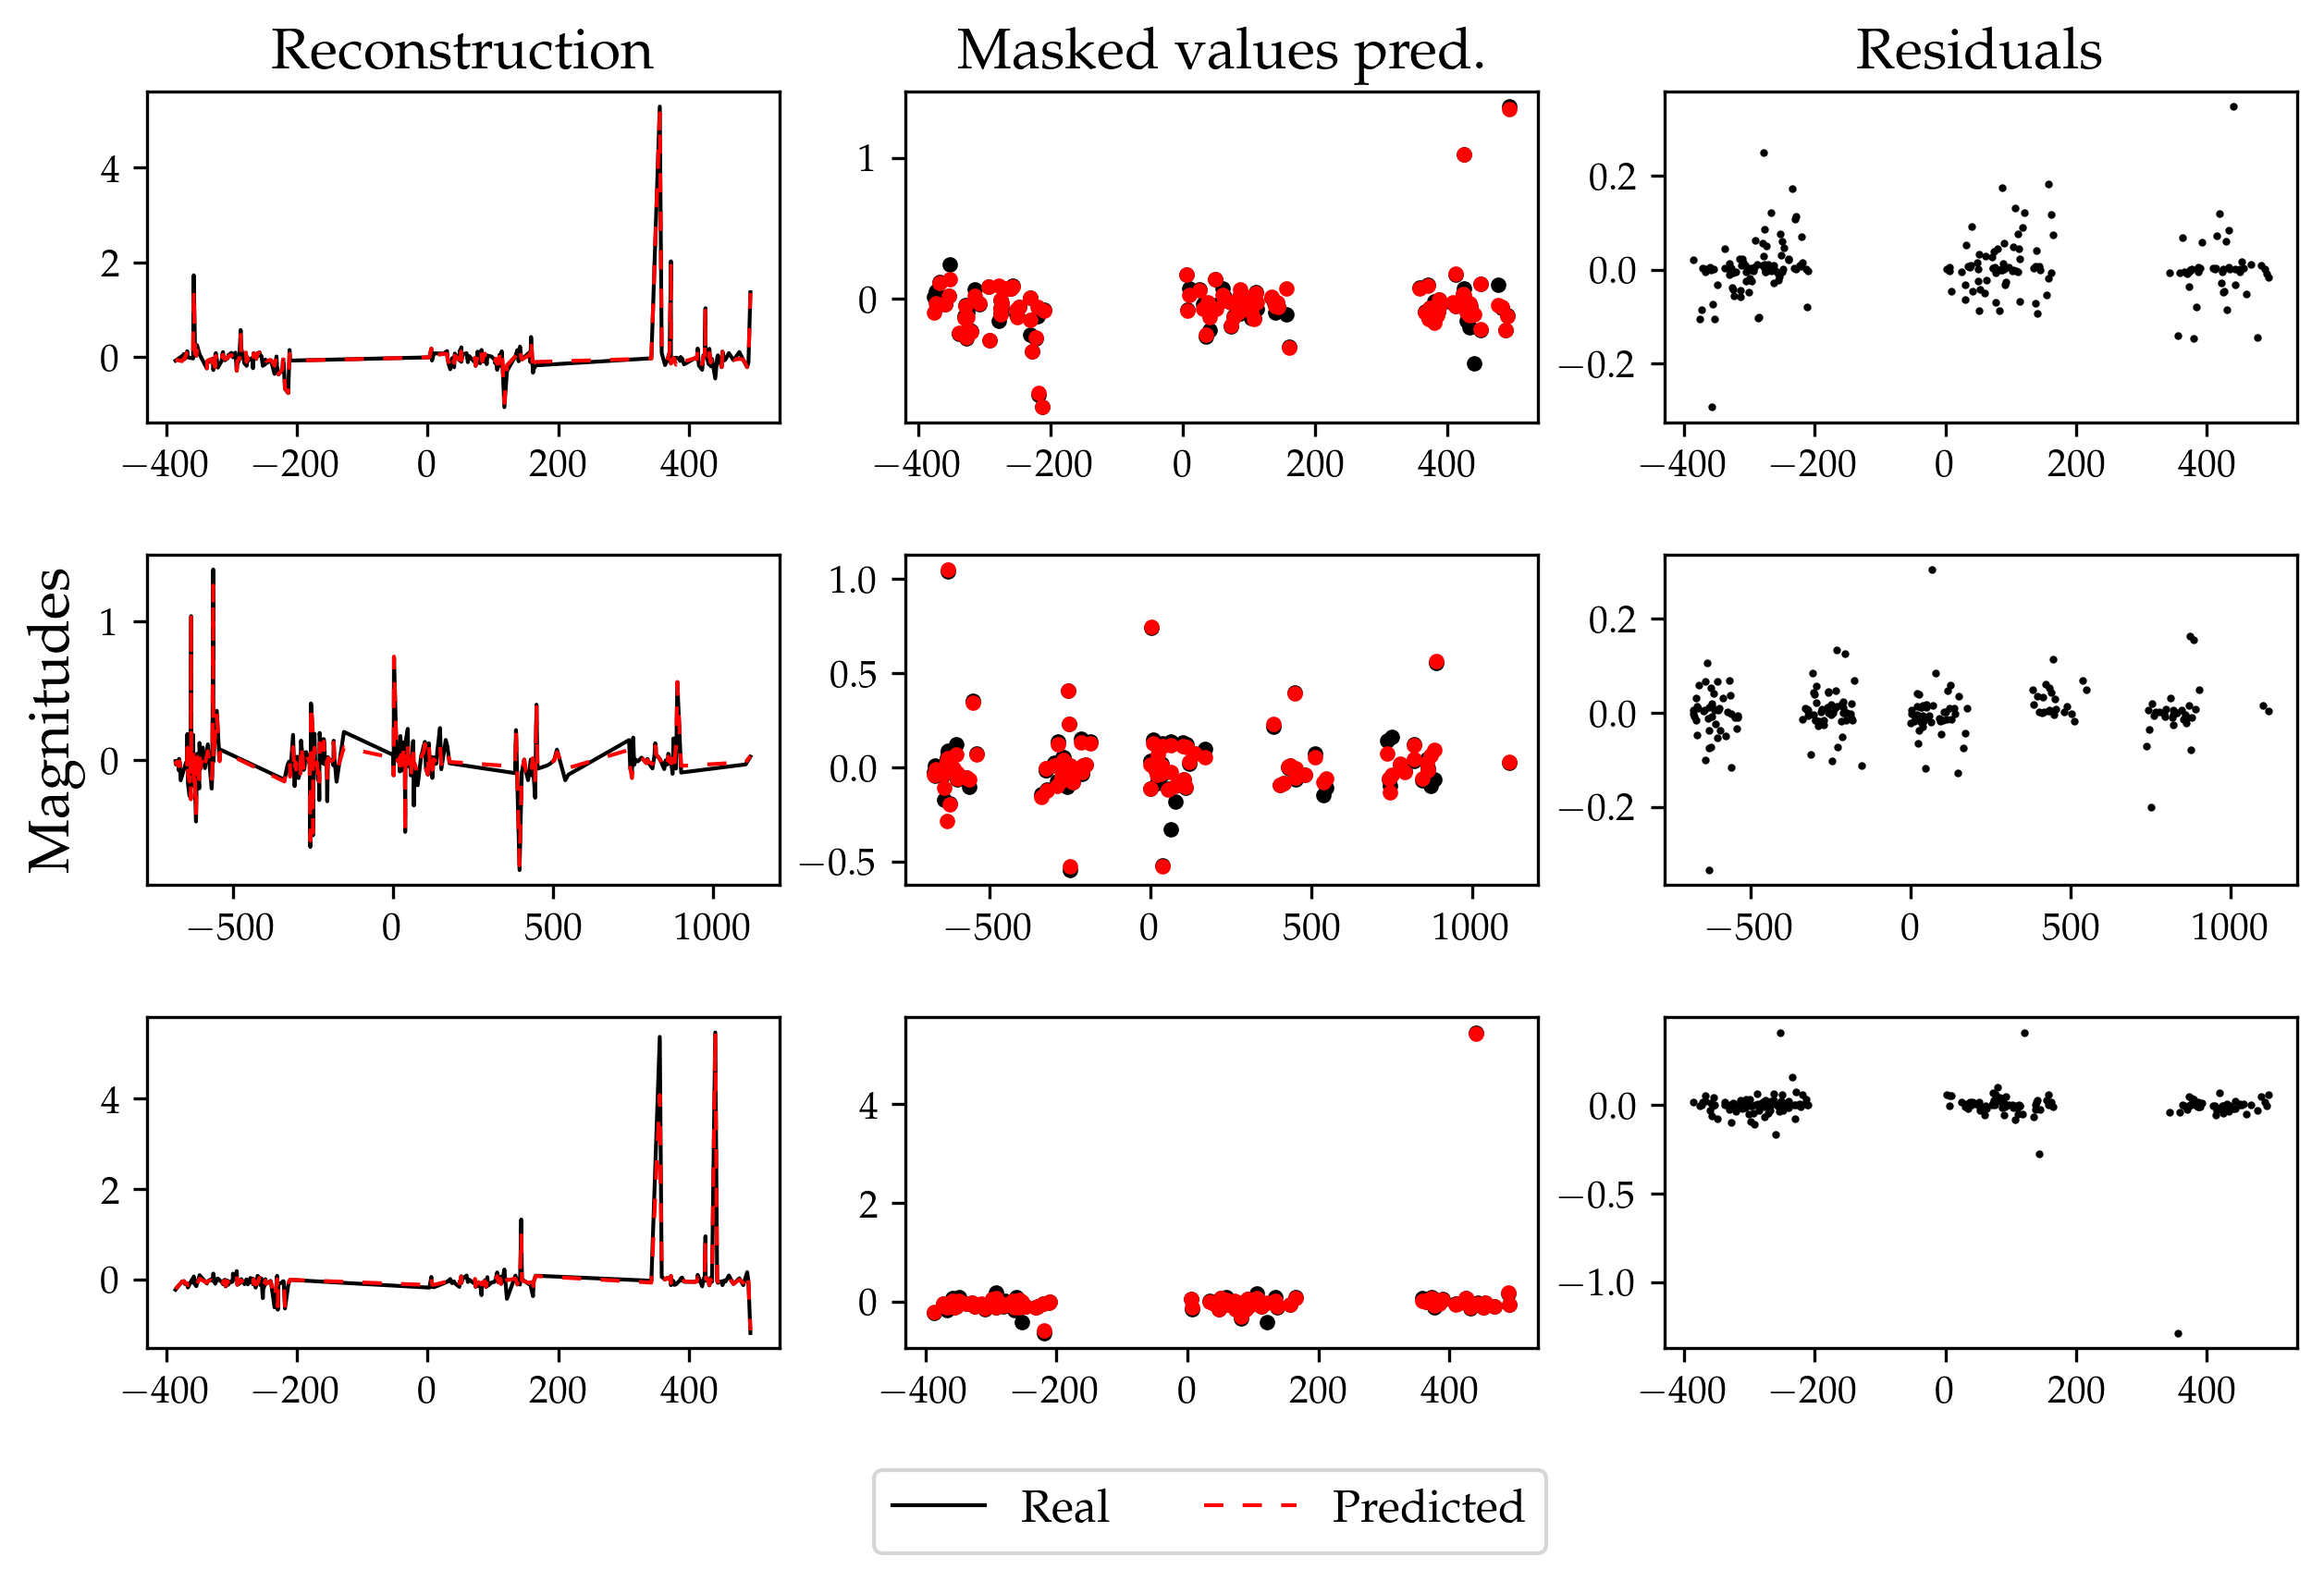

In [28]:
N = 3
fig, axes = plt.subplots(N, 3, dpi=300, figsize=(10,6),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.2},
                         sharey=False, sharex=False)

obs = conf['max_obs']//2

for i in range(N):

    times = result['time'][i]
    serie_pred = result['x_pred'][i]
    serie_true = result['x_true'][i]
    
    axes[i][0].plot(times, serie_true, marker='',linewidth=1, linestyle='-', color='k', label='Real')
    axes[i][0].plot(times, serie_pred, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5),label='Predicted')
    
    if i == 1:
        axes[i][0].set_ylabel('Magnitudes', fontsize=15)
    
    
    true_mask = tf.boolean_mask(result['x_true'][i], result['mask'][i])
    pred_mask = tf.boolean_mask(result['x_pred'][i], result['mask'][i])
    time_mask = tf.boolean_mask(times, result['mask'][i])

    axes[i][1].plot(time_mask, true_mask, marker='.',linewidth=1, linestyle='', color='k', label='Real')
    axes[i][1].plot(time_mask, pred_mask, marker='.',linewidth=1, linestyle='', color='red', label='Predicted')

    # RESIDUALS
    residuals = serie_pred - serie_true
    axes[i][2].plot(times, residuals, '.', markersize=2, color='k')
    
    if i == 0:
        axes[i][2].set_title('Residuals', fontsize=15)
        axes[i][1].set_title('Masked values pred.', fontsize=15)
        axes[i][0].set_title('Reconstruction', fontsize=15)
    
axes[-1][0].legend(ncol=3, bbox_to_anchor = (2.25, -0.3), fontsize=12)
fig.tight_layout()
# fig.savefig('presentation/figures/machito_pt_rec.pdf', format='pdf')#, transparent=True)

## Learning Curves

In [4]:
def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['tensors']}
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = tf.make_ndarray(v.tensor)
            metrics[v.tag].append(value)
    return metrics

In [5]:
model_0 = './runs/huge'
model_1 = './runs/huge/finetuning/huge_2'
model_2 = './runs/huge/finetuning/huge_2/finetuning/huge_3'
model_3 = './runs/huge/finetuning/huge_2/finetuning/huge_3/finetuning/huge_4'
model_4 = './runs/huge/finetuning/huge_2/finetuning/huge_3/finetuning/huge_4/finetuning/huge_5'

whole_val = []
whole_train = []
for m in [model_0, model_1, model_2, model_3, model_4]:
    train_metrics = get_metrics(os.path.join(m, 'logs', 'train'))
    val_metrics = get_metrics(os.path.join(m, 'logs', 'valid'))
    whole_val.append(val_metrics['mse'])
    whole_train.append(train_metrics['mse'])
    
train_metrics = {'mse':np.concatenate(whole_train)}
val_metrics = {'mse':np.concatenate(whole_val)}

In [6]:
# pathexp = 'weights/astromer_10022021/'
# train_metrics = get_metrics(os.path.join(pathexp, 'logs', 'train'))
# val_metrics = get_metrics(os.path.join(pathexp, 'logs', 'valid'))

In [11]:
from matplotlib.ticker import FuncFormatter

result = {'mse':0.148}

/tmp/ipykernel_2137745/1168690058.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set_ylim(0, 0.19)


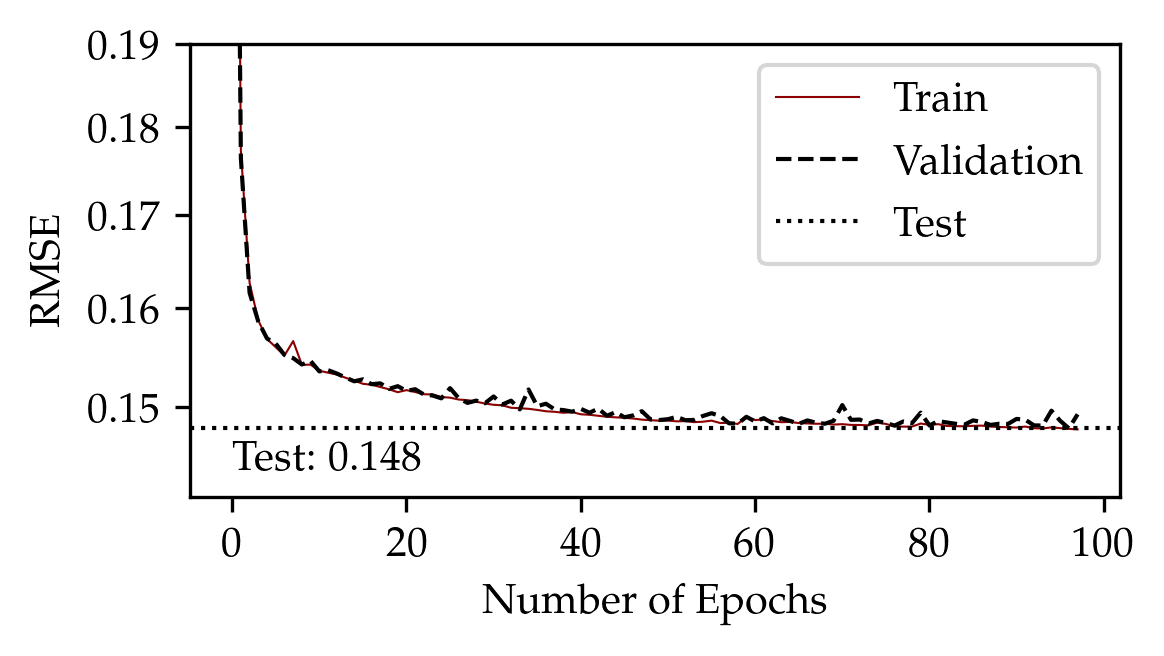

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(4,2), 
                         sharex=True, 
                         gridspec_kw={'hspace': 0.1, 'wspace': 0.3}, 
                         dpi=300)
for i, key in enumerate(train_metrics.keys()):
    if key != 'mse':continue
    train_values = np.array(train_metrics[key])

    train_values = train_values[np.arange(0, len(train_values), 10)]
    vaild_values = np.array(val_metrics[key])
    vaild_values = vaild_values[np.arange(0, len(vaild_values), 10)]
    
    axes.plot(train_values, label='Train', color='darkred', linewidth=0.5)
    axes.plot(vaild_values, label='Validation', color='k', linestyle='--', 
               linewidth=1)

    axes.set_ylabel('RMSE')
    axes.set_yscale('log')
        
axes.set_ylim(0, 0.19)
axes.axhline(result['mse'], linestyle=':', linewidth=1, 
             color='k', label='Test')

axes.text(0, result['mse']-0.004, 
          'Test: {:.3f}'.format(result['mse']), 
          color='k')

axes.legend(loc='upper right')
# fig.text(0.52, 0, 'Number of Epochs', ha='center')
axes.set_xlabel('Number of Epochs')
axes.set_yticks([0.15, 0.16, 0.17,0.18, 0.19])
axes.set_yticklabels([0.15, 0.16, 0.17,0.18, 0.19])
fig.savefig('presentation/figures/pretraining.pdf', format='pdf', bbox_inches='tight') #transparent=True
